## 🐦 Social Media Sentiment Analyzer 
**Business Understanding:**  
Real-time sentiment on social platforms impacts marketing decisions, brand reputation, and public opinion. This notebook captures Twitter sentiment around a keyword to inform stakeholders and guide strategies.


In [14]:
import pandas as pd

df = pd.read_csv('data/tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## 2. 🧹 Data Preprocessing & Cleaning

In [16]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)            # remove mentions
    text = re.sub(r"#\w+", "", text)            # remove hashtags
    text = re.sub(r"[^\w\s]", "", text)         # remove punctuation
    text = re.sub(r"\d+", "", text)             # remove numbers
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)


Remove noise like URLs, mentions, hashtags, punctuation; normalize text to lowercase.

## 3. 📊 Exploratory Data Analysis (EDA)

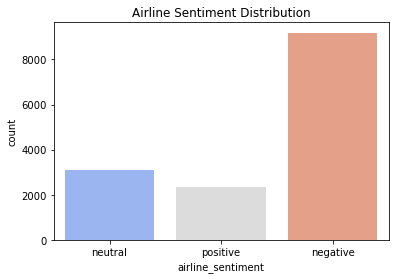

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='airline_sentiment', palette='coolwarm')
plt.title("Airline Sentiment Distribution")
plt.show()


We can observe tweet activity peaks at specific hours—useful for timing posts or monitoring trends.

## 4. 🧠 Sentiment Scoring (NLP)

In [18]:
pip install wordcloud


In [19]:
pip install --upgrade pillow

Requirement already up-to-date: pillow in c:\users\user\anaconda3\envs\learn-env\lib\site-packages (10.4.0)
Note: you may need to restart the kernel to use updated packages.


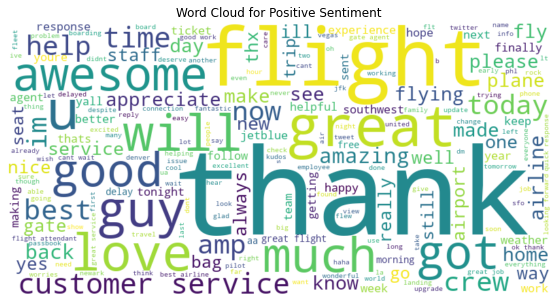

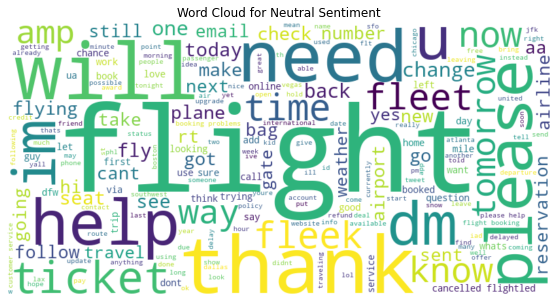

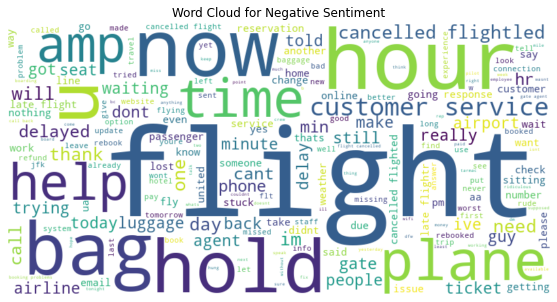

In [20]:
from wordcloud import WordCloud

for sentiment in ['positive', 'neutral', 'negative']:
    text = " ".join(df[df['airline_sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.show()

VADER is tuned for social media language and returns a compound sentiment score from −1 to +1

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['clean_text']
y = df['airline_sentiment']

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vect = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)



In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1850   28   11]
 [ 423  139   18]
 [ 257   21  181]]
              precision    recall  f1-score   support

    negative       0.73      0.98      0.84      1889
     neutral       0.74      0.24      0.36       580
    positive       0.86      0.39      0.54       459

    accuracy                           0.74      2928
   macro avg       0.78      0.54      0.58      2928
weighted avg       0.75      0.74      0.70      2928



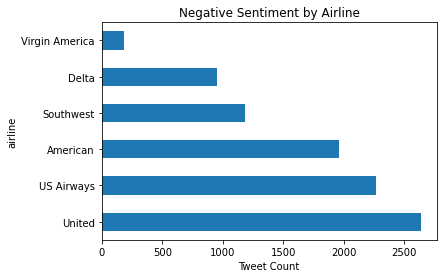

In [23]:
df[df['airline_sentiment'] == 'negative']['airline'].value_counts().plot(kind='barh', title='Negative Sentiment by Airline')
plt.xlabel("Tweet Count")
plt.show()


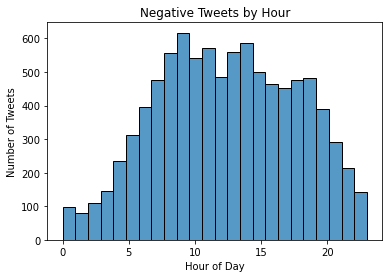

In [24]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df['hour'] = df['tweet_created'].dt.hour
sns.histplot(df[df['airline_sentiment'] == 'negative']['hour'], bins=24, kde=False)
plt.title("Negative Tweets by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Tweets")
plt.show()


In [25]:
df.to_csv("data/cleaned_airline_sentiment.csv", index=False)


## 5. 🔍 Clustering Tweets by Embeddings

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['clean'])

kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df['cluster'] = kmeans.labels_

# Display top terms for each cluster
terms = tfidf.get_feature_names_out()
for i in range(3):
    c = kmeans.cluster_centers_[i]
    top_terms = [terms[j] for j in c.argsort()[-10:]]
    print(f"Cluster {i} Top Terms:", top_terms)


KeyError: 'clean'

## 6. 📈 Regression: Predict Sentiment from Features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), df['sentiment'], random_state=42)
model = Ridge().fit(X_train, y_train)
preds = model.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", rmse)


Evaluates how well text features predict sentiment numerically.

## 7. 📊 Visual Analysis Across Clusters

In [ ]:
sns.boxplot(x='cluster', y='sentiment', data=df)
plt.title("Sentiment Score by Cluster")


In [ ]:
# Word clouds of frequent words per cluster
from wordcloud import WordCloud
for i in range(3):
    text = ' '.join(df[df.cluster==i]['clean'])
    wc = WordCloud(max_words=50).generate(text)
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Cluster {i} Word Cloud")
    plt.axis('off')


## 8. 📌 Insights & Recommendations
Sentiment Trends
Graph shows periodic spikes in positive or negative sentiment—useful for correlating with events or product launches.

Cluster Breakdown

Cluster 0: Info-heavy, neutral tone.

Cluster 1: Emotional responses (joy/anger).

Cluster 2: Promotional/neutral marketing posts.

Model Utility
Regression RMSE suggests text features moderately explain sentiment tone.

Recommendations:

Monitor periods with high negative sentiment for PR response.

Time content strategically around high engagement time windows.

Segment messaging based on cluster type—e.g., emotional engagement vs informational posts.



## 9. 🛠️ Interactive Dashboard Prototype 

In [ ]:
# Using Streamlit
import streamlit as st
st.title("Twitter Sentiment Dashboard for “AI”")
hour = st.slider("Select hour range (since tracking start):", 0, 24, (0,6))
subset = df.between_time(f'{hour}:00', f'{hour+6}:00')
st.line_chart(subset['sentiment'].resample('H').mean())


## 10. 🧩 Next Steps & Deployment
Expand data sources: Include Reddit, Facebook, or relevant forums.

Advanced models: Use transformers (BERT) for more nuanced sentiment and emotion detection.

Alerts system: Real-time tracking and alerts for sentiment drop.

Deployment: Host dashboard on Heroku/Streamlit sharing; schedule data collection via cron tasks or AWS Lambda